In [11]:
#Import Statements
import os, itertools
import warnings
from matplotlib.pyplot import text
from numpy import vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
import re
import numpy as np
import warnings
import statistics
import math
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from JaccardIndexUpdated import JaccardIndex, ClustersData, summary
from sklearn.decomposition import TruncatedSVD
from CleanText import getCleanText, getDataFrame
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from VectorizeHelperFunction import allScores
from CleanText import getCleanText, getText, getTextSameOutliers
import umap
import umap.plot
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
from django.urls import re_path as url
import holoviews as hv
import holoviews.operation.datashader as hd 
import umap
import umap.plot
import hdbscan
import time
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score

In [24]:
#Functions 
def printScores(df, labels):
    print("Silhouette Score:", silhouette_score(df, labels))
    print("Davies Bouldin Score:", davies_bouldin_score(df, labels))
    print("Calinski:", calinski_harabasz_score(df, labels))

In [ ]:
#Import Clean Text
text_l, labels = getCleanText("FraminghamClean", RemoveNums= True, stem = True)

In [142]:
#Import Raw Text
rawText, rawlabels = getText("55% outliers (w semi-loose clusters)")

#rawText, rawlabels = getTextSameOutliers("73% outelirs (w tight clusters)")

In [143]:
#Normal take in data
maxFreq = .8
minFreq = .005
ngramRange = (1,2)
startTimeTFIDF = time.perf_counter()
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(rawText)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = rawlabels,columns = tfidf_tokens)
endTimeTFIDF = time.perf_counter()

startTimeSVD = time.perf_counter()
svd = TruncatedSVD(n_components= 20)
reducedSVD = svd.fit_transform(df_tfidfvect)
endTimeSVD = time.perf_counter()


startTimeUMAP = time.perf_counter()
umapVectorizer = umap.UMAP(metric = 'cosine', n_neighbors = 10 , min_dist = 0.1)
reducedUMAP = umapVectorizer.fit_transform(df_tfidfvect)
endTimeUMAP = time.perf_counter()

fitUMAP = umapVectorizer.fit(df_tfidfvect)

print(f'\nTFIDF Time: {(endTimeTFIDF - startTimeTFIDF) / 60}')
print(f'SVD Time: {(endTimeSVD - startTimeSVD) / 60}')
print(f'UMAP Time: {(endTimeUMAP - startTimeUMAP) / 60}')



TFIDF Time: 0.10607691666664323
SVD Time: 0.034754801666652686
UMAP Time: 0.48163309166666296


In [ ]:
fig = umap.plot.points(fitUMAP, labels = np.array(rawlabels), width = 1300, height = 1300)

In [ ]:
umap.plot.diagnostic(fitUMAP, diagnostic_type='neighborhood')

In [102]:
#Test one clusterer
start_time = time.perf_counter()
#clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=5, min_samples=2, cluster_selection_method = 'leaf')'
clusterer = hdbscan.HDBSCAN(algorithm = 'best', gen_min_span_tree=True, min_cluster_size=5, min_samples=20, cluster_selection_method = 'leaf')
clusterer.fit(reducedUMAP)
end_time = time.perf_counter()

#print(f'\nTime: {(end_time - start_time) / 60}\n')

clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
df = pd.DataFrame(data = clusterDict, index = rawlabels)
#print(df.to_string())
clusterProbabilities = clusterer.probabilities_
clusterLabels =   clusterer.labels_
outlierScores =   clusterer.outlier_scores_
clusterValidity = clusterer.relative_validity_
negative = -1

for x in range(len(clusterLabels)):
    if(clusterLabels[x] == -1):
        clusterLabels[x] = negative
        negative = negative - 1

clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities, "Outlier Scores": outlierScores}
df = pd.DataFrame(data = clusterDict, index = rawlabels)

print("Number of clusters:", len(set(clusterLabels)))
print("Number of documents:", len(clusterLabels))

print("Homogenity score:", homogeneity_score(rawlabels, clusterLabels))
print("Completeness score:", completeness_score(rawlabels, clusterLabels))
print("Density Based Cluster Validity:", clusterValidity)
print("Normalized Mutual Info Score:", normalized_mutual_info_score(rawlabels, clusterLabels))
print(df.to_string())


Number of clusters: 180
Number of documents: 471
Homogenity score: 0.6313715160948774
Completeness score: 1.0000000000000002
Density Based Cluster Validity: 0.24782186127574862
Normalized Mutual Info Score: 0.7740376853044898
                                                                                                                                              Cluster Label  Cluster probabilities  Outlier Scores
106962_Cashflow- WE 02 June 2007.xls.txt                                                                                                                 -1               0.000000        0.045553
106972_Cashflow- WE 23 June 2007.xls.txt                                                                                                                 -2               0.000000        0.037714
106996_Cashflow- WE 30 June 2007.xls.txt                                                                                                                 -3               0.000000        0.0

In [103]:
#Cluster Parameters
sample = [1, 2, 5, 10, 20, 40]
epsilons = [0]
sampleSize = [2]
clusterMethod = ['eom', 'leaf']
clusterSizes = []
clusterSizesParam = []
highestNMI = 0
highestNMIparam = {}
highestDBV = 0
highestDBVparam = {}
for z in sample:
    for y in epsilons:
        for j in sampleSize:
            for k in clusterMethod:
                print("Epsilons:", y)
                print("Min_sample:", z)
                print("Min_cluster_size:", j)
                print("Cluster Method:", k)
                start_time = time.perf_counter()
                #clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=5, min_samples=2, cluster_selection_method = 'leaf')'
                clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=j, min_samples= z, gen_min_span_tree=True, cluster_selection_epsilon = y, cluster_selection_method = k)
                clusterer.fit(reducedUMAP)
                end_time = time.perf_counter()

                #print(f'\nTime: {(end_time - start_time) / 60}\n')

                clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
                df = pd.DataFrame(data = clusterDict, index = rawlabels)
                #print(df.to_string())
                clusterProbabilities = clusterer.probabilities_
                clusterLabels =   clusterer.labels_
                outlierScores =   clusterer.outlier_scores_
                clusterValidity = clusterer.relative_validity_
                negative = -1
                for x in range(len(clusterLabels)):
                    if(clusterLabels[x] == -1):
                        clusterLabels[x] = negative
                        negative = negative - 1
                

                """clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities, "Outlier Scores": outlierScores, "nmi"}
                df = pd.DataFrame(data = clusterDict, index = rawlabels)
                """
                parameters = {"Epsilon": y, "Min Sample": z, "Min Cluster Size": j, "Cluster Method": k, "Number of clusters": len(set(clusterLabels)), "homogenity":homogeneity_score(rawlabels, clusterLabels), "completeness":completeness_score(rawlabels, clusterLabels)}

                print("Number of clusters:", len(set(clusterLabels)))
                print("Number of documents:", len(clusterLabels))

                print("Homogenity score:", homogeneity_score(rawlabels, clusterLabels))
                print("Completeness score:", completeness_score(rawlabels, clusterLabels))
                print("Density Based Cluster Validity:", clusterValidity)
                print("Normalized Mutual Info Score:", normalized_mutual_info_score(rawlabels, clusterLabels))
                clusterSizes.append(len(set(clusterLabels)))
                clusterSizesParam.append({"clusters": len(set(clusterLabels)), "parameters": parameters, "DBV": clusterValidity, "NMI": normalized_mutual_info_score(rawlabels, clusterLabels)})
                print()
                #print(df.to_string())

                if(clusterValidity > highestDBV):
                    highestDBV = clusterValidity
                    highestDBVparam = parameters
                if(normalized_mutual_info_score(rawlabels, clusterLabels) > highestNMI):
                    highestNMI = normalized_mutual_info_score(rawlabels, clusterLabels)
                    highestNMIparam = parameters
                


clusterSizes.sort()
clusterSizesNoDup = pd.Series(clusterSizes).drop_duplicates().tolist()
print((clusterSizesNoDup))
#print(clusterSizesParam)
newlist = sorted(clusterSizesParam, key=lambda d: d['clusters']) 

#print("Cur NMI:", curNMI)
print("Best NMI", highestNMI)
print("Best clusters:", highestNMIparam)

print("Best DBV", highestDBV)
print("Best clusters:", highestDBVparam)


Epsilons: 0
Min_sample: 1
Min_cluster_size: 2
Cluster Method: eom
Number of clusters: 175
Number of documents: 471
Homogenity score: 0.8061602225015215
Completeness score: 0.9999999999999997
Density Based Cluster Validity: 0.3767590319913896
Normalized Mutual Info Score: 0.8926785259227935

Epsilons: 0
Min_sample: 1
Min_cluster_size: 2
Cluster Method: leaf
Number of clusters: 212
Number of documents: 471
Homogenity score: 0.8494058378218635
Completeness score: 0.9999999999999997
Density Based Cluster Validity: 0.3270459666818031
Normalized Mutual Info Score: 0.9185715979162806

Epsilons: 0
Min_sample: 2
Min_cluster_size: 2
Cluster Method: eom
Number of clusters: 131
Number of documents: 471
Homogenity score: 0.7216737250463366
Completeness score: 0.9999999999999996
Density Based Cluster Validity: 0.32375036203400437
Normalized Mutual Info Score: 0.83833970925811

Epsilons: 0
Min_sample: 2
Min_cluster_size: 2
Cluster Method: leaf
Number of clusters: 177
Number of documents: 471
Homogeni

Number of clusters: 14
Number of documents: 571
Homogenity score: 0.18563352399712937
Completeness score: 0.9463545997620436
Density Based Cluster Validity: 0.312831657802291
Normalized Mutual Info Score: 0.31038336112808096
{'Min Sample': 20, 'Cluster Method': 'eom', 'Number of clusters': 14, 'homogenity': 0.18563352399712937, 'completeness': 0.9463545997620436}



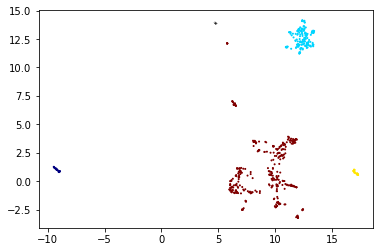

'#print("Cur NMI:", curNMI)\nprint("Best NMI", highestNMI)\nprint("Best clusters:", highestNMIparam)\n\nprint("Best DBV", highestDBV)\nprint("Best clusters:", highestDBVparam)'

In [156]:
#Adjustable Sample Size

def AdjustableSize(number, vectorizedData, textLabels):
    if(number == 1):
        sample = 1
        clusterMethod = 'leaf'
    if(number == 2):
        sample = 2
        clusterMethod = 'leaf'
    if(number == 3):
        sample = 5
        clusterMethod = 'eom'
    if(number == 4):
        sample = 10
        clusterMethod = 'eom'
    if(number == 5):
        sample = 20
        clusterMethod = 'eom'

    clusterSizes = []
    clusterSizesParam = []
    highestNMI = 0
    highestNMIparam = {}
    highestDBV = 0
    highestDBVparam = {}

    clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=2, min_samples= sample, gen_min_span_tree=True, cluster_selection_method = clusterMethod)
    clusterer.fit(reducedUMAP)

    clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
    df = pd.DataFrame(data = clusterDict, index = rawlabels)
    clusterProbabilities = clusterer.probabilities_
    clusterLabels =   clusterer.labels_
    outlierScores =   clusterer.outlier_scores_
    clusterValidity = clusterer.relative_validity_
    negative = -1
    for x in range(len(clusterLabels)):
        if(clusterLabels[x] == -1):
            clusterLabels[x] = negative
            negative = negative - 1


    parameters = {"Min Sample": sample, "Cluster Method": clusterMethod, "Number of clusters": len(set(clusterLabels)), "homogenity":homogeneity_score(textLabels, clusterLabels), "completeness":completeness_score(textLabels, clusterLabels)}

    print("Number of clusters:", len(set(clusterLabels)))
    print("Number of documents:", len(clusterLabels))

    print("Homogenity score:", homogeneity_score(textLabels, clusterLabels))
    print("Completeness score:", completeness_score(textLabels, clusterLabels))
    print("Density Based Cluster Validity:", clusterValidity)
    print("Normalized Mutual Info Score:", normalized_mutual_info_score(rawlabels, clusterLabels))
    print(parameters)
    clusterSizes.append(len(set(clusterLabels)))
    clusterSizesParam.append({"clusters": len(set(clusterLabels)), "parameters": parameters, "DBV": clusterValidity, "NMI": normalized_mutual_info_score(textLabels, clusterLabels)})
    print()



    if(clusterValidity > highestDBV):
        highestDBV = clusterValidity
        highestDBVparam = parameters
    if(normalized_mutual_info_score(textLabels, clusterLabels) > highestNMI):
        highestNMI = normalized_mutual_info_score(rawlabels, clusterLabels)
        highestNMIparam = parameters

    plt.scatter(reducedUMAP[clusterLabels>=0, 0], reducedUMAP[clusterLabels>=0, 1], c=clusterLabels[clusterLabels>=0], s=1,
            cmap=plt.cm.jet)
    plt.scatter(reducedUMAP[clusterLabels<0, 0], reducedUMAP[clusterLabels<0, 1], c='k', s=1, marker='x', alpha=0.2)
    plt.show()
                
AdjustableSize(5, reducedUMAP, rawlabels)

clusterSizes.sort()
clusterSizesNoDup = pd.Series(clusterSizes).drop_duplicates().tolist()
#print((clusterSizesNoDup))
#print(clusterSizesParam)
newlist = sorted(clusterSizesParam, key=lambda d: d['clusters']) 

"""#print("Cur NMI:", curNMI)
print("Best NMI", highestNMI)
print("Best clusters:", highestNMIparam)

print("Best DBV", highestDBV)
print("Best clusters:", highestDBVparam)"""


[clusteval] >Fit using hdbscan with metric: euclidean, and linkage: single
[clusteval] >Estimated number of clusters: 2
[clusteval] >Silhouette Coefficient: 0.675
[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.
[clusteval] >Estimated number of n_clusters: 2, average silhouette_score=0.751


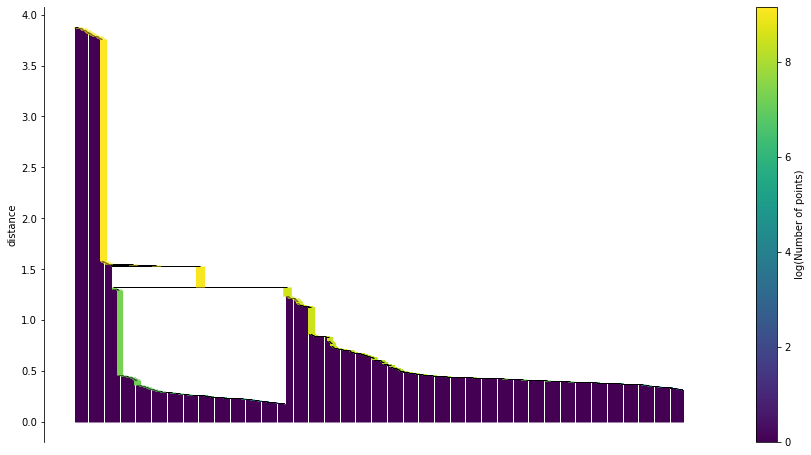

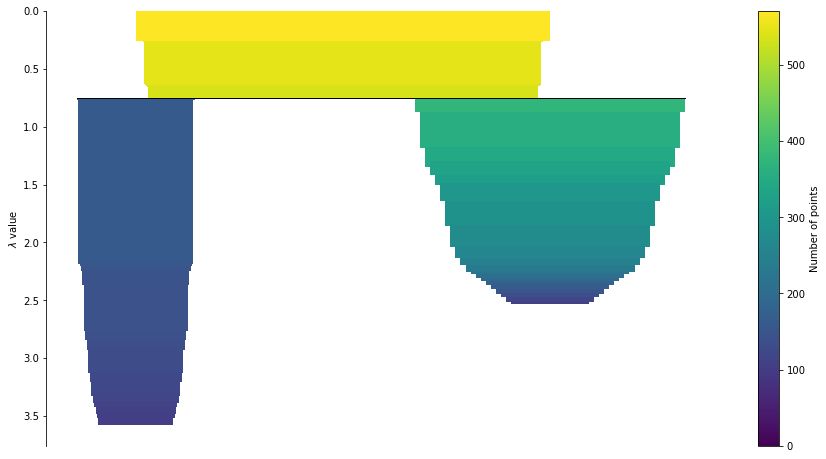

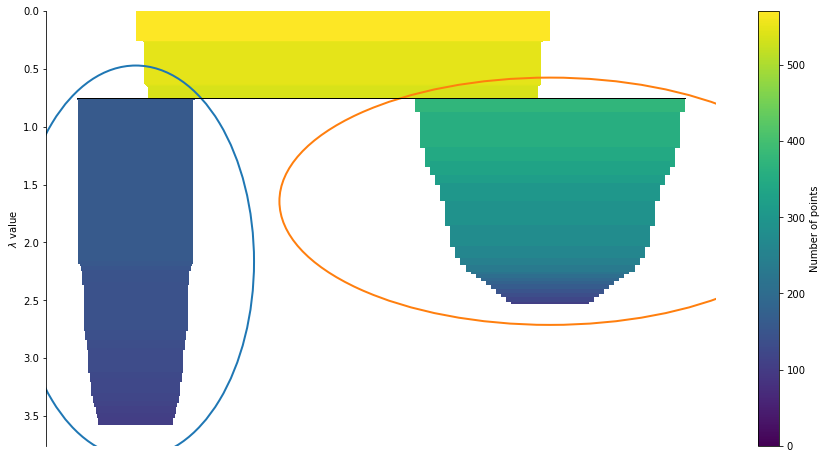

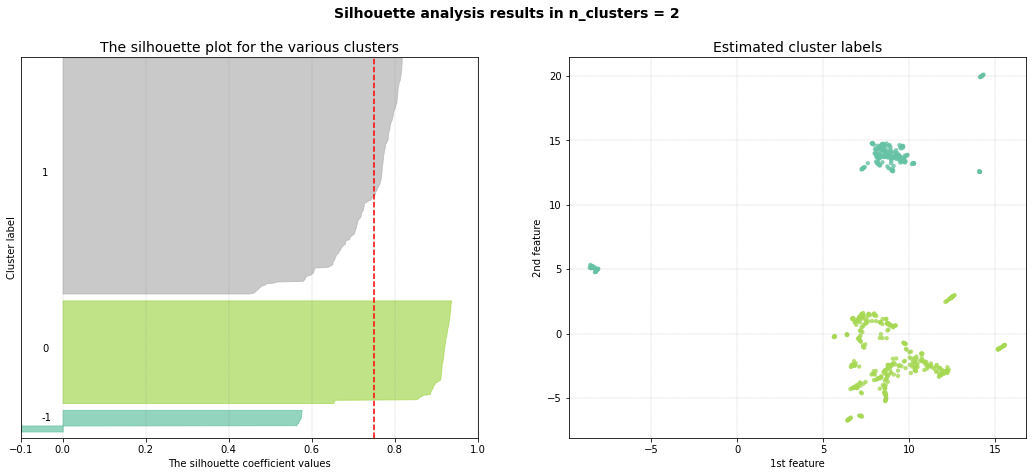

(<Figure size 1296x504 with 2 Axes>,
 <AxesSubplot:title={'center':'The silhouette plot for the various clusters'}, xlabel='The silhouette coefficient values', ylabel='Cluster label'>,
 <AxesSubplot:title={'center':'Estimated cluster labels'}, xlabel='1st feature', ylabel='2nd feature'>)

In [80]:
# Import library
from clusteval import clusteval
# Set the method
ce = clusteval(cluster='hdbscan', linkage = 'single', min_clust = 100, max_clust= 500, )
# Evaluate
results = ce.fit(reducedUMAP)
# Make plot of the evaluation
ce.plot()
# Make scatter plot using the first two coordinates. 
ce.scatter(reducedUMAP)

In [ ]:
from scipy.cluster.hierarchy import fcluster

clusterer = hdbscan.HDBSCAN()
clusterer.fit(reducedUMAP)
Z = clusterer.single_linkage_tree_.to_numpy()
labels = fcluster(Z, 2, criterion='maxclust')

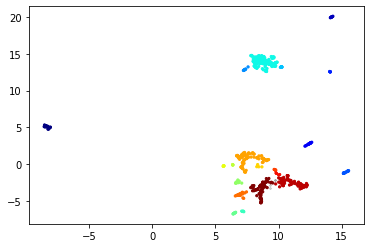

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Homogenity score: 0.4465147621455154
Completeness score: 0.9761306172336897
Normalized Mutual Info Score: 0.6127412167426424
                                      Cluster Label  Cluster probabilities
Alloys                                            7               1.000000
Alloys                                            7               1.000000
Alloys                                            7               1.000000
Alloys                                            7               1.000000
Alloys                                            7               1.000000
Alloys                                            7               1.000000
Alloys                                            7               1.000000
Asian Countries                                   7               1.000000
Asian Countries                                   7               1.000000
Asian Countries            

In [73]:

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from hdbscan import HDBSCAN
from hdbscan.flat import (HDBSCAN_flat, approximate_predict_flat, membership_vector_flat, all_points_membership_vectors_flat)
from hdbscan import flat

clusterer = HDBSCAN_flat(reducedUMAP, n_clusters = 20, min_cluster_size=2)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.scatter(reducedUMAP[labels>=0, 0], reducedUMAP[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(reducedUMAP[labels<0, 0], reducedUMAP[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

clusterDict = {"Cluster Label": (labels), "Cluster probabilities": proba}
df = pd.DataFrame(data = clusterDict, index = rawlabels)
print("Homogenity score:", homogeneity_score(rawlabels, labels))
print("Completeness score:", completeness_score(rawlabels, labels))
print("Normalized Mutual Info Score:", normalized_mutual_info_score(rawlabels, labels))
print(df.to_string())

In [139]:
docs_df = pd.DataFrame(text_l, columns=["Doc"])
docs_df['Topic'] = clusterer.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

ValueError: Length of values (471) does not match length of index (630)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(text_l))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [141]:
#Cluster Parameters
sample = [1, 2, 5, 10, 20, 40]
epsilons = [0, 0.5, 1]
sampleSize = [2, 5, 10]
clusterMethod = ['eom', 'leaf']
clusterSizes = []
clusterSizesParam = []
highestNMI = 0
highestNMIparam = {}
highestDBV = 0
highestDBVparam = {}
for z in sample:
    for y in epsilons:
        for j in sampleSize:
            for k in clusterMethod:
                print("Epsilons:", y)
                print("Min_sample:", z)
                print("Min_cluster_size:", j)
                print("Cluster Method:", k)
                start_time = time.perf_counter()
                #clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=5, min_samples=2, cluster_selection_method = 'leaf')'
                clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=j, min_samples= z, gen_min_span_tree=True, cluster_selection_epsilon = y, cluster_selection_method = k)
                clusterer.fit(reducedUMAP)
                end_time = time.perf_counter()

                #print(f'\nTime: {(end_time - start_time) / 60}\n')

                clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
                df = pd.DataFrame(data = clusterDict, index = rawlabels)
                #print(df.to_string())
                clusterProbabilities = clusterer.probabilities_
                clusterLabels =   clusterer.labels_
                outlierScores =   clusterer.outlier_scores_
                clusterValidity = clusterer.relative_validity_
                negative = -1
                for x in range(len(clusterLabels)):
                    if(clusterLabels[x] == -1):
                        clusterLabels[x] = negative
                        negative = negative - 1

                """clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities, "Outlier Scores": outlierScores, "nmi"}
                df = pd.DataFrame(data = clusterDict, index = rawlabels)
                """
                parameters = {"Epsilon": y, "Min Sample": z, "Min Cluster Size": j, "Cluster Method": k, "Number of clusters": len(set(clusterLabels)), "homogenity":homogeneity_score(rawlabels, clusterLabels), "completeness":completeness_score(rawlabels, clusterLabels)}

                print("Number of clusters:", len(set(clusterLabels)))
                print("Number of documents:", len(clusterLabels))

                print("Homogenity score:", homogeneity_score(rawlabels, clusterLabels))
                print("Completeness score:", completeness_score(rawlabels, clusterLabels))
                print("Density Based Cluster Validity:", clusterValidity)
                print("Normalized Mutual Info Score:", normalized_mutual_info_score(rawlabels, clusterLabels))
                clusterSizes.append(len(set(clusterLabels)))
                clusterSizesParam.append({"clusters": len(set(clusterLabels)), "parameters": parameters, "DBV": clusterValidity, "NMI": normalized_mutual_info_score(rawlabels, clusterLabels)})
                print()
                #print(df.to_string())

                if(clusterValidity > highestDBV):
                    highestDBV = clusterValidity
                    highestDBVparam = parameters
                if(normalized_mutual_info_score(rawlabels, clusterLabels) > highestNMI):
                    highestNMI = normalized_mutual_info_score(rawlabels, clusterLabels)
                    highestNMIparam = parameters
                


clusterSizes.sort()
clusterSizesNoDup = pd.Series(clusterSizes).drop_duplicates().tolist()
print((clusterSizesNoDup))
#print(clusterSizesParam)
newlist = sorted(clusterSizesParam, key=lambda d: d['clusters']) 

#Find two lowest
curNMI = 0
bestNMIclusters = 0
bestClusterIndex = 0
for x in range(len(newlist)):
    if(newlist[x]["DBV"] > curNMI):
        curNMI = newlist[x]["DBV"]
        bestNMIclusters = newlist[x]["clusters"]
        bestClusterIndex = x
        highestNMIparam = newlist[x]["parameters"]

#print("Cur NMI:", curNMI)
print("Best DBV", bestNMIclusters)
print("Best clusters:", highestNMIparam)

def printLargestSecondLargest(startIDX, finalIDX, newlist):
    largestParam = {}
    secondLargestParam = {}
    largest = -1
    second_largest = -1
    if(startIDX + 1 >= len(newlist)):
        return largest, largestParam, second_largest, secondLargestParam
    if newlist[startIDX]["DBV"] > newlist[startIDX + 1]["DBV"]: # NEW
        largest = newlist[startIDX]["DBV"]
        largestParam = newlist[startIDX]["parameters"]
        second_largest = newlist[startIDX + 1]["DBV"]
        secondLargestParam = newlist[startIDX + 1]["DBV"]
    else: # NEW
        largest = newlist[startIDX + 1]["DBV"] # NEW
        largestParam = newlist[startIDX + 1]["parameters"]
        second_largest = newlist[startIDX]["DBV"] # NEW
        secondLargestParam = newlist[startIDX]["parameters"]
    # Only look at the part of inlist starting with item 2
    for item in newlist[startIDX + 2:finalIDX]:
        if item["DBV"] > largest:
            second_largest = largest
            secondLargestParam = largestParam
            largest = item["DBV"]
            largestParam = item["parameters"]
        elif largest > item["DBV"] > second_largest:
            second_largest = item["DBV"]
            secondLargestParam = item["parameters"]
    return largest, largestParam, second_largest, secondLargestParam

print("Best cluster index:", bestClusterIndex)
print("New List:", len(newlist))

first, firstParam, second, secondParam = printLargestSecondLargest(0, bestClusterIndex, newlist)

print("First:", first)
print("First Param:", firstParam)
print("Second:", second)
print("Second Param:", secondParam)

fourth, fourthParam, five, fiveParam = printLargestSecondLargest(bestClusterIndex + 1, len(newlist), newlist)

print("Fourth:", fourth)
print("Fourth Param:", fourthParam)
print("Fifth:", five)
print("Fifth Param:", fiveParam)


#print(newlist)
"""print(highestDBV)
print(highestDBVparam)
print(highestNMI)
print(highestNMIparam)"""



Epsilons: 0
Min_sample: 1
Min_cluster_size: 2
Cluster Method: eom
Number of clusters: 189
Number of documents: 471
Homogenity score: 0.8485268454062121
Completeness score: 0.9072979469538383
Density Based Cluster Validity: 0.35139900749545305
Normalized Mutual Info Score: 0.876928800780259

Epsilons: 0
Min_sample: 1
Min_cluster_size: 2
Cluster Method: leaf
Number of clusters: 214
Number of documents: 471
Homogenity score: 0.88011093562316
Completeness score: 0.9103263762101876
Density Based Cluster Validity: 0.3173672939650954
Normalized Mutual Info Score: 0.8949636978559158

Epsilons: 0
Min_sample: 1
Min_cluster_size: 5
Cluster Method: eom
Number of clusters: 95
Number of documents: 471
Homogenity score: 0.7072430023988033
Completeness score: 0.9575883527840583
Density Based Cluster Validity: 0.4197035388651127
Normalized Mutual Info Score: 0.8135931120912057

Epsilons: 0
Min_sample: 1
Min_cluster_size: 5
Cluster Method: leaf
Number of clusters: 131
Number of documents: 471
Homogenity

'print(highestDBV)\nprint(highestDBVparam)\nprint(highestNMI)\nprint(highestNMIparam)'

In [ ]:
color_palette = sns.color_palette()
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(reducedUMAP[:,0], reducedUMAP[:,1], s=5, c=cluster_member_colors, alpha=1)

In [67]:
#Cluster Parameters
sample = [1, 2, 5, 10, 20, 40]
clusterSizes = []
clusterSizesParam = []
highestNMI = 0
highestNMIparam = {}
highestDBV = 0
highestDBVparam = {}
for k in sample:

    print("Cluster Method:", k)
    start_time = time.perf_counter()
    #clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=5, min_samples=2, cluster_selection_method = 'leaf')'
    clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=2, min_samples= k, gen_min_span_tree=True, cluster_selection_method = 'leaf')
    clusterer.fit(reducedUMAP)
    end_time = time.perf_counter()

    #print(f'\nTime: {(end_time - start_time) / 60}\n')

    clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
    df = pd.DataFrame(data = clusterDict, index = rawlabels)
    #print(df.to_string())
    clusterProbabilities = clusterer.probabilities_
    clusterLabels =   clusterer.labels_
    outlierScores =   clusterer.outlier_scores_
    clusterValidity = clusterer.relative_validity_
    negative = -1
    for x in range(len(clusterLabels)):
        if(clusterLabels[x] == -1):
            clusterLabels[x] = negative
            negative = negative - 1

    clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities, "Outlier Scores": outlierScores}
    df = pd.DataFrame(data = clusterDict, index = rawlabels)

    parameters = {"Epsilon": y, "Min Sample": z, "Min Cluster Size": j, "Cluster Method": k, "Number of clusters": len(set(clusterLabels))}

    print("Number of clusters:", len(set(clusterLabels)))
    print("Number of documents:", len(clusterLabels))

    print("Homogenity score:", homogeneity_score(rawlabels, clusterLabels))
    print("Completeness score:", completeness_score(rawlabels, clusterLabels))
    print("Density Based Cluster Validity:", clusterValidity)
    print("Normalized Mutual Info Score:", normalized_mutual_info_score(rawlabels, clusterLabels))
    clusterSizes.append(len(set(clusterLabels)))
    clusterSizesParam.append({"cluste"})
    print()
    #print(df.to_string())

    if(clusterValidity > highestDBV):
        highestDBV = clusterValidity
        highestDBVparam = parameters
    if(normalized_mutual_info_score(rawlabels, clusterLabels) > highestNMI):
        highestNMI = normalized_mutual_info_score(rawlabels, clusterLabels)
        highestNMIparam = parameters

Cluster Method: 1
Number of clusters: 200
Number of documents: 471
Homogenity score: 0.8579192024355141
Completeness score: 0.9011438735806865
Density Based Cluster Validity: 0.33263260984531035
Normalized Mutual Info Score: 0.8790004677408989

Cluster Method: 2
Number of clusters: 201
Number of documents: 471
Homogenity score: 0.8493354437843246
Completeness score: 0.9280920684463866
Density Based Cluster Validity: 0.29171502339843236
Normalized Mutual Info Score: 0.8869689294246804

Cluster Method: 5
Number of clusters: 191
Number of documents: 471
Homogenity score: 0.7974594507648363
Completeness score: 0.9534695627702341
Density Based Cluster Validity: 0.25334027483875976
Normalized Mutual Info Score: 0.8685141521672659

Cluster Method: 10
Number of clusters: 171
Number of documents: 471
Homogenity score: 0.7347699621253636
Completeness score: 0.9643189982757232
Density Based Cluster Validity: 0.33128067205362693
Normalized Mutual Info Score: 0.8340382997633754

Cluster Method: 20
